In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [29]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCHS = 100

In [30]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    directory= '/kaggle/input/dataset/us_data',
    shuffle= True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE 
)

Found 1672 files belonging to 2 classes.


In [31]:
type(data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [32]:
class_names = data.class_names
class_names

['ü', 'ş']

In [33]:
len(data)

105

/tmp/ipykernel_35/2134204738.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


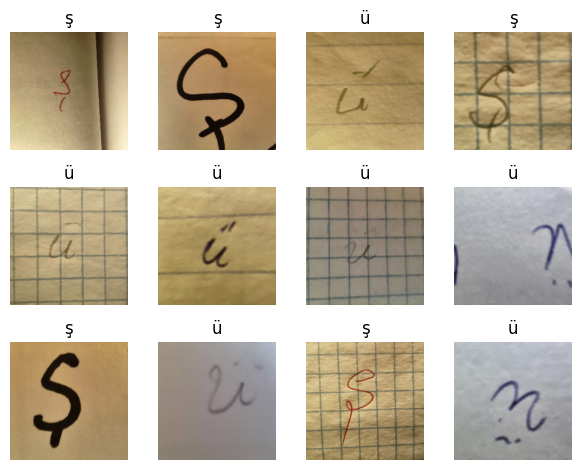

In [34]:
for image_bach, image_label in data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_bach[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[image_label[i]])
        plt.tight_layout()
    plt.show()

In [35]:
len(data)

105

In [36]:
def tra_tes_val_split(data, train_size = 0.7, test_size = 0.2):
    data = data.shuffle(1000, seed = 42)
    data_size = len(data)
    
    train_data = data.take(int(train_size * data_size))
    test_val_data = data.skip(int(train_size * data_size))
    test_data = test_val_data.take(int(test_size * data_size))
    val_data = test_val_data.skip(int(test_size * data_size))

    return train_data, test_data, val_data
    

In [37]:
train_data, test_data, val_data = tra_tes_val_split(data)

In [38]:
print('Overall Data Batch size:', len(data))
print('Train Data Batch size:', len(train_data))
print('Test Data Batch size:', len(test_data))
print('Val Data Batch size:', len(val_data))

Overall Data Batch size: 105
Train Data Batch size: 73
Test Data Batch size: 21
Val Data Batch size: 11


In [39]:
train_data = train_data.cache().shuffle(1000, seed = 0).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000, seed = 0).prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000, seed = 0).prefetch(buffer_size = tf.data.AUTOTUNE)

In [40]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0/255),
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)
])

In [41]:
data_argumentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(factor=0.2)
])

In [42]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = tf.keras.Sequential([
    resize_and_rescale,
    data_argumentation,
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = input_shape),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    #tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    #tf.keras.layers.MaxPool2D((2, 2)),
    #tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    #tf.keras.layers.MaxPool2D((2, 2)),
    #tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    #tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (16, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (16, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (16, 254, 254, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (16, 127, 127, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (16, 125, 125, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (16, 62, 62, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (16, 123008)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (16, 32)                    │       3,936,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (16, 2)                     │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,941,442 (15.04 MB)

 Trainable params: 3,941,442 (15.04 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [45]:
history = model.fit(
    train_data,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_data,
    verbose = 1
)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.5136 - loss: 2.0309 - val_accuracy: 0.4602 - val_loss: 0.7203
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6449 - loss: 0.6101 - val_accuracy: 0.6477 - val_loss: 0.5930
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6380 - loss: 0.5875 - val_accuracy: 0.7784 - val_loss: 0.5218
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6984 - loss: 0.5517 - val_accuracy: 0.7216 - val_loss: 0.5105
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7288 - loss: 0.5178 - val_accuracy: 0.7784 - val_loss: 0.5000
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7199 - loss: 0.5106 - val_accuracy: 0.6818 - val_loss: 0.5243
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7206 - loss: 0.5255 - val_accuracy: 0.8068 - val_loss: 0.4441
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7197 - loss: 0.4952 - val_accuracy: 0

In [46]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 73}

In [47]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

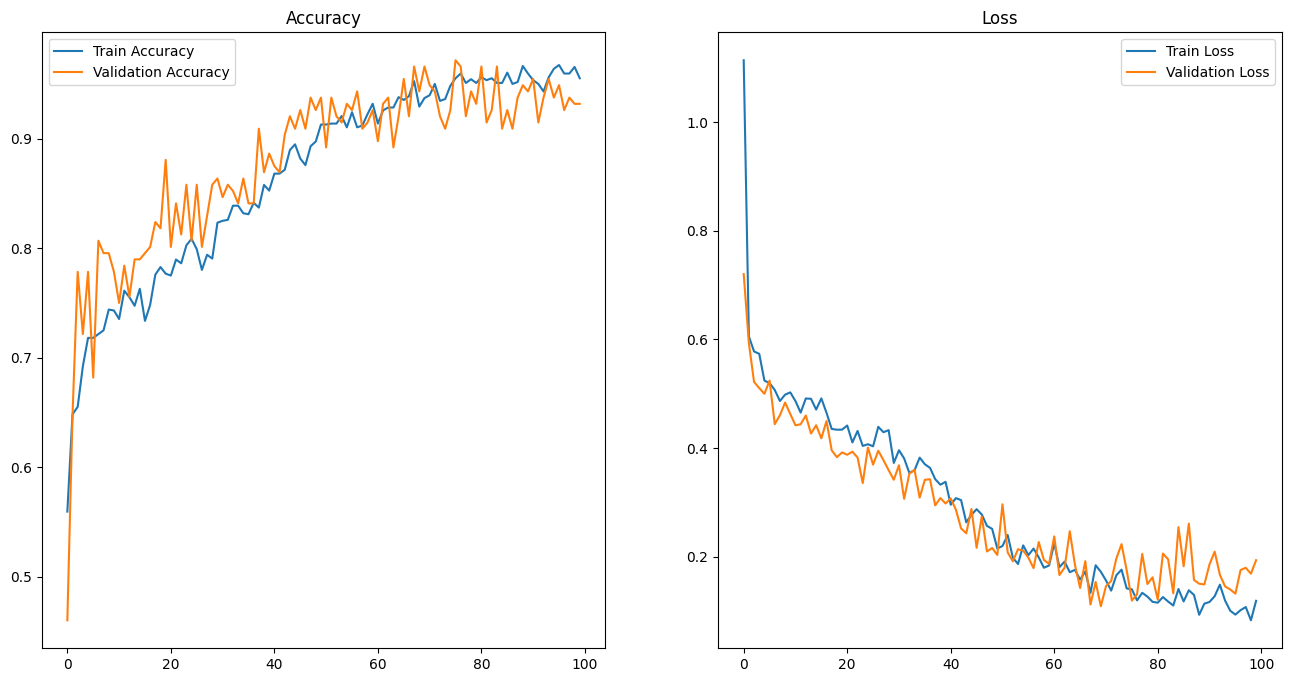

In [49]:
plt.figure(figsize = (16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Train Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Train Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.title('Loss')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted as: ş


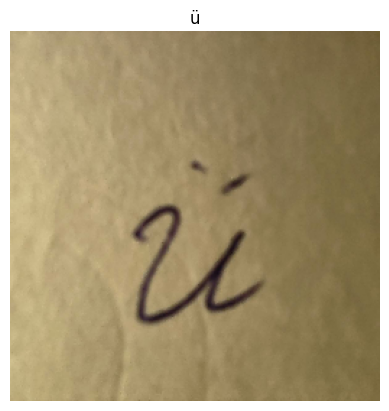

In [57]:
for images_batch, labels_batch in test_data.take(1):
    first_image = images_batch[1].numpy().astype('uint8')
    first_label = labels_batch[1].numpy()

    plt.imshow(first_image)   
    plt.title(class_names[first_label])
    plt.axis('off')

    bach_prediction = model.predict(images_batch)
    print('Predicted as:', class_names[np.argmax(bach_prediction[1])])

In [51]:
all_true_labels = []
all_predictions = []

for images_batch, labels_batch in test_data:
    # Get predictions for the current batch
    batch_predictions = model.predict(images_batch, verbose=0)
    
    # Convert labels to numpy and extend the list
    true_labels_batch = labels_batch.numpy()
    all_true_labels.extend(true_labels_batch)
    
    # Get predicted class indices (argmax) and extend the list
    predicted_classes_batch = np.argmax(batch_predictions, axis=1)
    all_predictions.extend(predicted_classes_batch)


true_labels = np.array(all_true_labels)
predictions = np.array(all_predictions)

print(f"Total test samples: {len(true_labels)}")
print(f"Shape of true_labels: {true_labels.shape}")
print(f"Shape of predictions: {predictions.shape}")

# Prediction probabilities (confidence) 
all_prediction_probs = []
for images_batch, labels_batch in test_data:
    batch_predictions = model.predict(images_batch, verbose=0)
    all_prediction_probs.extend(batch_predictions)

prediction_probabilities = np.array(all_prediction_probs)
print(f"Shape of prediction_probabilities: {prediction_probabilities.shape}")

# Display first few predictions vs true labels
print("\nFirst 10 samples:")
for i in range(min(10, len(true_labels))):
    true_class = class_names[true_labels[i]]
    pred_class = class_names[predictions[i]]
    confidence = prediction_probabilities[i][predictions[i]]
    print(f"True: {true_class}, Predicted: {pred_class}, Confidence: {confidence:.3f}")

Total test samples: 336
Shape of true_labels: (336,)
Shape of predictions: (336,)
Shape of prediction_probabilities: (336, 2)

First 10 samples:
True: ü, Predicted: ü, Confidence: 0.006
True: ü, Predicted: ü, Confidence: 0.827
True: ş, Predicted: ş, Confidence: 0.001
True: ü, Predicted: ü, Confidence: 0.916
True: ü, Predicted: ü, Confidence: 0.000
True: ü, Predicted: ü, Confidence: 0.000
True: ş, Predicted: ş, Confidence: 0.963
True: ü, Predicted: ü, Confidence: 0.054
True: ü, Predicted: ü, Confidence: 0.973
True: ş, Predicted: ş, Confidence: 0.183


In [66]:
import sklearn
sklearn.__version__

'1.2.2'


CLASSIFICATION METRICS
Accuracy:  0.8929
Precision: 0.8929
Recall:    0.8929
F1-Score:  0.8928

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

           ü       0.89      0.91      0.90       177
           ş       0.90      0.87      0.89       159

    accuracy                           0.89       336
   macro avg       0.89      0.89      0.89       336
weighted avg       0.89      0.89      0.89       336


PER-CLASS METRICS
ü               - Precision: 0.8895, Recall: 0.9096, F1: 0.8994
ş               - Precision: 0.8968, Recall: 0.8742, F1: 0.8854

CONFUSION MATRIX
[[161  16]
 [ 20 139]]


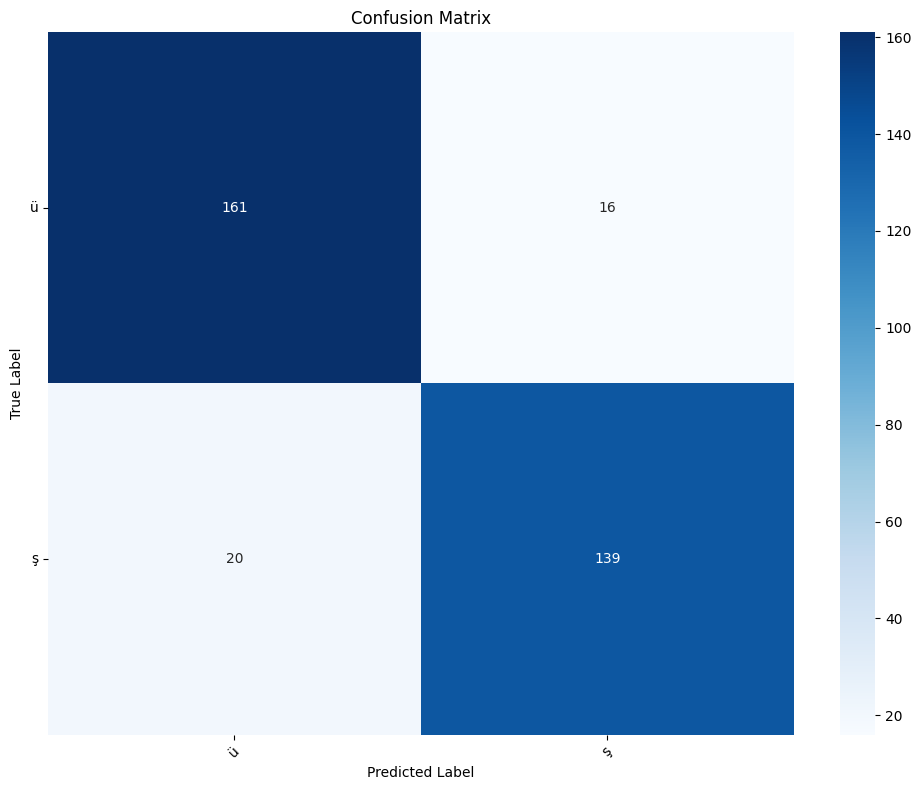


ROC AUC Score: 0.4837

ADDITIONAL METRICS
Macro Precision: 0.8931
Macro Recall:    0.8919
Macro F1-Score:  0.8924

Micro Precision: 0.8929
Micro Recall:    0.8929
Micro F1-Score:  0.8929

PREDICTIONS SUMMARY
ü               - Correct: 161/177 (Accuracy: 0.9096)
ş               - Correct: 139/159 (Accuracy: 0.8742)


In [52]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*50)
print("CLASSIFICATION METRICS")
print("="*50)

# Basic Metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Detailed Classification Report
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(true_labels, predictions, target_names=class_names))

# Per-class metrics
print("\n" + "="*50)
print("PER-CLASS METRICS")
print("="*50)
precision_per_class = precision_score(true_labels, predictions, average=None)
recall_per_class = recall_score(true_labels, predictions, average=None)
f1_per_class = f1_score(true_labels, predictions, average=None)

for i, class_name in enumerate(class_names):
    print(f"{class_name:15} - Precision: {precision_per_class[i]:.4f}, "
          f"Recall: {recall_per_class[i]:.4f}, F1: {f1_per_class[i]:.4f}")

# Confusion Matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(true_labels, predictions)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ROC AUC Score (for multi-class)
try:
    # Binarize the labels for multi-class ROC AUC
    num_classes = len(class_names)
    true_labels_bin = label_binarize(true_labels, classes=range(num_classes))
    
    # Calculate ROC AUC using prediction probabilities
    if num_classes > 2:
        roc_auc = roc_auc_score(true_labels_bin, prediction_probabilities, multi_class='ovr', average='weighted')
        print(f"\nROC AUC Score (weighted): {roc_auc:.4f}")
    else:
        # For binary classification
        roc_auc = roc_auc_score(true_labels, prediction_probabilities[:, 1])
        print(f"\nROC AUC Score: {roc_auc:.4f}")
        
except Exception as e:
    print(f"\nROC AUC calculation failed: {e}")

# Additional useful metrics
print("\n" + "="*50)
print("ADDITIONAL METRICS")
print("="*50)

# Macro and Micro averages
macro_precision = precision_score(true_labels, predictions, average='macro')
macro_recall = recall_score(true_labels, predictions, average='macro')
macro_f1 = f1_score(true_labels, predictions, average='macro')

micro_precision = precision_score(true_labels, predictions, average='micro')
micro_recall = recall_score(true_labels, predictions, average='micro')
micro_f1 = f1_score(true_labels, predictions, average='micro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-Score:  {macro_f1:.4f}")
print()
print(f"Micro Precision: {micro_precision:.4f}")
print(f"Micro Recall:    {micro_recall:.4f}")
print(f"Micro F1-Score:  {micro_f1:.4f}")

# Calculate number of correct/incorrect predictions per class
print("\n" + "="*50)
print("PREDICTIONS SUMMARY")
print("="*50)
for i, class_name in enumerate(class_names):
    class_mask = (true_labels == i)
    correct_predictions = np.sum((true_labels == i) & (predictions == i))
    total_samples = np.sum(class_mask)
    class_accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    
    print(f"{class_name:15} - Correct: {correct_predictions:3d}/{total_samples:3d} "
          f"(Accuracy: {class_accuracy:.4f})")

In [53]:
#model.save('/kaggle/working/.h5')